# The Louvain algorithm for network community detection

Here I present a complete description of modularity and the Louvain algorithm for finding a graph partition (coloring) that is locally optimal. The code for this 

## Data
The algorithm works on any weighted-nondirected network. This data could come in the form of a graphml, csv, spreadsheet etc. Whatever the format is, there is a specific format that we need to convert it to so that the following codes know what to do with it. The format we use here is a python dictionary in which the keys are the edges and the values are the weights of those edges. For example, 


In [246]:
graph={('a','b'):1,('a','c'):2,('b','c'):2,('c','d'):1,('d','e'):4,('e','g'):1,('f','g'):4,('f','d'):1,('f','f'):1}

describes a network of the type we want to work with. Lets take a look at what this network looks like;

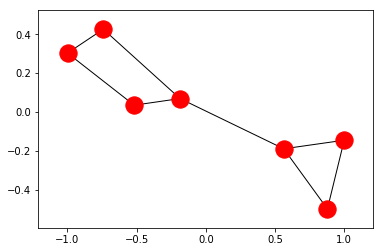

In [247]:
import networkx as nx
import matplotlib.pyplot as plt

plt.figure()
G=nx.Graph()
for edge in graph:
    G.add_edge(edge[0],edge[1],weight=graph[edge])
    
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
plt.show()

## Calculating modularity
The Louvain algorithm maximizes a property known as modularity. If each node has a color then the modularity measures the relative likelihood that edges in the network will connect nodes of the same color. For example we can asign the following colors:

In [248]:
color= {'a': 'c0', 'b':'c1', 'c':'c2', 'd':'c1', 'e':'c1', 'f':'c0','g':'c2'} 

to get

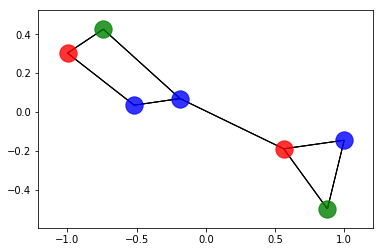

In [249]:
plt.figure()

color_list=['r','b','g','c','m','orange','yellow','k','pink']
n=0
for c in set(color.values()):
    nodes=[node for node in color if color[node]==c]
    nx.draw_networkx_nodes(G,pos,nodelist=nodes, node_color=color_list[n],alpha=0.8)
    n=n+1
    nx.draw_networkx_edges(G,pos)
plt.show()

Modularity was priginally defined in Newman's 2004 paper to be
\begin{equation}
Q=\\sum_{c}\\left(e_{cc}-a_{c}^{2}\\right)
\end{equation}
where $e_{cc}$ denotes the fraction of the total weight of edges that both begin and end at nodes of color $c$, and $a_{c}$ is the fraction of weight the total weight of edges that end (or begin) at nodes of color $c$. 

### A note of the definition of modularity
The Louvain paper refers to 
The definition given in the louvain paper is expressed differently as
\begin{equation}
Q=\frac{1}{S}\sum_{i,j}\left[w_{ij}-\frac{s_{i}s_{j}}{S}\right]\delta(c_{i},c_{j})
\end{equation}
where $w_{ij}$ is the weight of the edge between $i$ and $j$, $s_{i}=\sum_{j}w_{ij}$, and $S=\sum_{i}s_{i}$. The $\delta$ used here is the Kronecker delta  function; $\delta(x,y)=1$ if $x=y$, and 0 otherwise. The notation $\sum_{ij}$ means the sum over all elements in a matrix, in this case it is the matrix whose $i,j$th element is $w_{ij}-s_{i}s_{j}/S$. Note that this is not the same as the sum over all pairs of nodes since it counts each pair of nodes twice (with the exception of pairs that consist of the same node twice). 

Here I will explain why these two definitions are not the same. First, if $G$ is a graph and $G_{c}$ is the subgraph of nodes of color $c$ then 
 $e_{cc}$ is defined as
\begin{equation}
e_{cc}=\frac{1}{W}\sum_{(i,j)\in G_{c}}w_{ij}
\end{equation}
where $W$ is the total weight of the graph, and  
\begin{equation}
W=\sum_{(i,j)\in G}w_{ij}=\frac{1}{2}\left[S+\sum_{i}w_{ii}\right].
\end{equation}
To make it look more like the first term in the Louvain equation we note that 
\begin{equation}
\sum_{(i,j)\in G_{c}}w_{ij}=\frac{1}{2}\left[\sum_{i,j}w_{ij}+\sum_{i}w_{ii}\right]\delta(c,c_{i})\delta(c,c_{j})
\end{equation}
so 
\begin{equation}
e_{cc}=\frac{1}{2W}\left[\sum_{i,j}w_{ij}+\sum_{i}w_{ii}\right]\delta(c,c_{i})\delta(c,c_{j}).
\end{equation}

Next, the Newman paper defines $a_{c}$ as fraction of the weight of edges that connect to nodes of color $c$. It then goes on to say that in a randomly colored graph the expectation is $e_{c1c2}=a_{c1}a_{c2}$ but this is incorrect. Consider the following graph:









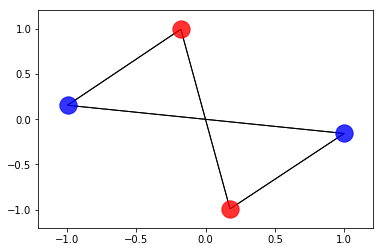

In [250]:
plt.figure()
graph2={('a','b'):1,('b','c'):1,('c','d'):1,('d','a'):1}
G2=nx.Graph()
for edge in graph2:
    G2.add_edge(edge[0],edge[1],weight=graph2[edge])
pos2=nx.spring_layout(G2)
color2={'a': 'c0', 'b':'c0', 'c':'c1', 'd':'c1'} 
n=0
for c in set(color2.values()):
    nodes2=[node for node in color2 if color2[node]==c]
    nx.draw_networkx_nodes(G2,pos2,nodelist=nodes2, node_color=color_list[n],alpha=0.8)
    n=n+1
    nx.draw_networkx_edges(G2,pos2)
plt.show()

Here $a_{red}=3/4$ and $a_{blue}=3/4$ which means the null expectation for the fraction of weight between red and red is $9/16$, the same for edges between blue and blue, and the same for edges between red and blue. Adding these together we ought to get $1$ but instead we get $27/16$. A better definition (that appears to have been used in the  Louvain definition of modularity) is that $a_{c}$ is the fraction of ends of edges that are attached to nodes of color $c$,
\begin{equation}
a_{c}=\frac{1}{S}\sum_{i\in G_{c}}s_{i}.
\end{equation}
Now the expectation for the weight of edges between red and red is $(1/2)\times(1/2)$ and its the same for blue and blue. For edges that go from one color to the other, the expectation is $2\times(1/2)\times(1/2)$ since there are effectively two ways that the edge can be placed, either the red stub could be selected then the blue one, or the blue one is selected first then the red. From this definition the sum of these expected fractions is $1$, as it should be.

For Newman's formula we need to know $a_{c}^{2}$. Noting that
\begin{equation}
\begin{split}
a_{c}^{2}&=\frac{1}{S^{2}}\left[\sum_{i\in G_{c}}s_{i}\right]^{2}\\
&=\frac{1}{S^{2}}\sum_{i,j}s_{i}s_{j}\delta(c,c_{i})\delta(c,c_{j})
\end{split}
\end{equation}
we have 
\begin{equation}
Q=\sum_{c}\left[\sum_{i,j}w_{ij}+\sum_{i}w_{ii}\right]\delta(c,c_{i})\delta(c,c_{j})-\sum_{i,j}s_{i}s_{j}\delta(c,c_{i})\delta(c,c_{j})
\end{equation}
which can be rewritten
\begin{equation}
Q=\sum_{i,j}\left[\frac{w_{ij}}{2W}-\frac{s_{i}s_{j}}{S^{2}}\right]\delta(c_{i},c_{j})+\sum_{i}\frac{w_{ii}}{2W}.
\end{equation}
Comparing this to the definition given in the Louvain paper we see two differences: an extra term that depends on the weight of the self-loops, and that the two terms within the sum have different denominators. If the network contains no self-loops then $S=2W$ and the two definitions become equivalent to each other. In other words, Newman's definition of modularity and the version used in the Louvain paper are only the same if there are no self-loops.

To make the calculation of modularity as fast as possible we can reduce the number of operations by summing over each distinct pair of nodes in the network rather than summing over every matrix element. First lets get a list of the nodes,

In [251]:
nodes=sorted(list(set([edge[0] for edge in graph]+[edge[1] for edge in graph])))
N=len(nodes)
print('nodes:',nodes)

nodes: ['a', 'b', 'c', 'd', 'e', 'f', 'g']


Now we need to know the weight of edges between each distinct pair:

In [252]:
Weight={}
for i in nodes:
    for j in nodes:
        edge=tuple(sorted([i,j]))
        if (i,j) in graph:
            Weight[edge]=graph[(i,j)]
        elif (j,i) in graph:
            Weight[edge]=graph[(j,i)]
        else:
            Weight[edge]=0
print(Weight)

{('a', 'a'): 0, ('a', 'b'): 1, ('a', 'c'): 2, ('a', 'd'): 0, ('a', 'e'): 0, ('a', 'f'): 0, ('a', 'g'): 0, ('b', 'b'): 0, ('b', 'c'): 2, ('b', 'd'): 0, ('b', 'e'): 0, ('b', 'f'): 0, ('b', 'g'): 0, ('c', 'c'): 0, ('c', 'd'): 1, ('c', 'e'): 0, ('c', 'f'): 0, ('c', 'g'): 0, ('d', 'd'): 0, ('d', 'e'): 4, ('d', 'f'): 1, ('d', 'g'): 0, ('e', 'e'): 0, ('e', 'f'): 0, ('e', 'g'): 1, ('f', 'f'): 1, ('f', 'g'): 4, ('g', 'g'): 0}


Notice that when we read the edge from the network we sort it. This prevents the same edge form appearing twice in the dictionary.

The sum over matrix elements ($\sum_{i,j}$) relates to the sum over distinct pairs of nodes ($\sum_{(i,j)}$) in the following way:
\begin{equation}
\sum_{(i,j)}w_{ij}=\frac{1}{2}\left[\sum_{i,j}w_{ij}+\sum_{i}w_{ii}\right].
\end{equation}
and so the modularity equation can be expressed as 
\begin{equation}
Q=\sum_{i}\left(\frac{s_{i}}{S}\right)^{2}+\sum_{(i,j)}\left[\frac{w_{ij}}{W}-\frac{2s_{i}s_{j}}{S^{2}}\right]\delta(c_{i},c_{j}).
\end{equation}

### Computing modularity

The formula above turns out to be quite easy to write as code. First, we will want to know the strength of every node ($s_{i}$ for all nodes $i$).

In [253]:
strength={}
for i in nodes:
    strength[i]=sum([graph[edge] for edge in graph if edge[0]==i or edge[1]==i])
print('strength:',strength)

strength: {'a': 3, 'b': 3, 'c': 5, 'd': 6, 'e': 5, 'f': 6, 'g': 5}


and the total strength (S)

In [254]:
total_strength=sum([strength[i] for i in nodes])
print('total strength:',total_strength)

total strength: 33


and the total weight (W)

In [255]:
total_weight=sum([graph[edge] for edge in graph])
print('total weightt:',total_weight)

total weightt: 17


Now we can put it all together to find the modularity

In [256]:
Q=sum([(strength[i]/total_strength)**2 for i in nodes])
for edge in Weight:
    i=edge[0]
    j=edge[1]
    if color[i]==color[j]: 
        Q=Q+Weight[edge]/(total_weight)-2*strength[i]*strength[j]/(total_strength**2)

print('Modularity of this coloring =',Q)

Modularity of this coloring = -0.05207151731215902


This code is included in the Louvain module and can be accessed as follows:

In [257]:
import Louvain
print('Q =',Louvain.modularity(Weight,color))

Q = -0.05207151731215902


For comparison, I also copied the code from the python community library. 

In [258]:
print('Q =',Louvain.net_x_modularity(color,G))

links 17.0
Q = -0.04844290657439447


The small difference in the result is because of the existence of self-loop in the graph; in $\verb|net_x_modularity|$, self-loops are considered to attach to the same node twice the weight of a self-loop is counted twice when calculating the strength of a node (which I believe is incorrect). Additionally, the denominator for the second term is $2W$ when it should be $S$. 

## Finding an optimal coloring

This is where the Louvain algorithm begins. Actually, to make things easier later on we first want to create an adjacency list for every node. We start with an empty dictionary and add each node as a neighbor of itself

In [259]:
neighbors={}
for i in nodes:
    neighbors[i]=list(set([edge[0] for edge in graph if edge[1]==i]+[edge[1] for edge in graph if edge[0]==i]))  

print(neighbors)

{'a': ['c', 'b'], 'b': ['c', 'a'], 'c': ['d', 'b', 'a'], 'd': ['f', 'c', 'e'], 'e': ['g', 'd'], 'f': ['f', 'g', 'd'], 'g': ['f', 'e']}


The procedure starts by asigning a unique color to every node. We are going to keep track of the node colors using a dictionary

In [260]:
# color tells us the color of each node
color={}
for n in range(N):
    i=nodes[n]
    # this will be the label for the color
    c='c'+str(n)
    color[i]=c 
print(color)

{'a': 'c0', 'b': 'c1', 'c': 'c2', 'd': 'c3', 'e': 'c4', 'f': 'c5', 'g': 'c6'}


The first part of the procedure is to compute the change in modularity that occurs when the color of a node changes. For a node, $i$ that changes color from $c1$ to $c2$ the magnitude of this change is 
\begin{equation}
\Delta Q=\frac{w_{i,c2}}{W}-\frac{2s_{i}(s_{i}+w_{c2})}{S^{2}}-\frac{w_{i,c1}}{W}+\frac{2s_{i}w_{c1}}{S^{2}}
\end{equation}

Where $w_{i,c}$ denotes the weight of edges adjacent to $i$ that link to nodes of color $c$, initially this is 

In [261]:
weight_in_color={}  
for j in nodes:
    for i in nodes:
        if i in neighbors[j]:
            weight_in_color[(i,color[j])]=Weight[tuple(sorted((i,j)))]
        else:
            weight_in_color[(i,color[j])]=0

and we need to know $w_{c}$ the total weight of edges of edges attached to nodes of color $c$

In [262]:
total_weight_of_color={}
for c in set(color.values()):
    total_weight_of_color[c]=sum([strength[i] for i in nodes if color[i]==c])

When each node is considered, the source is the color that it currently is and the target is the color that it may change to. T1 - T4 are the four terms in the equation for $\Delta Q$.

In [263]:
i='a'
source='c0'
target='c2'

T1 =(weight_in_color[(i,target)]+Weight[(i,i)])/total_weight

T2 =2*strength[i]*(strength[i]+total_weight_of_color[target])/(total_strength**2)
 
T3=weight_in_color[(i,source)]/total_weight

T4=2*strength[i]*total_weight_of_color[source]/total_strength**2
    
# compute the total change if ID moved from source community to target community
delta_Q=T1-T2-T3+T4

Just to prove that the formula is correct we can calculate the modularity befor and after making the change

In [264]:
Q_before=Louvain.modularity(Weight,color)
# make the change
color[i]=target
Q_after=Louvain.modularity(Weight,color)
print(Q_after-Q_before)
print(delta_Q)

# now reset it to how it was before so we don't mess things up!
color[i]=source

0.09009884945713824
0.09009884945713822


Now we have finally reached the fun part! The following is a loop that sequentially chooses nodes. It calculates, for every color, the change in Q that would occur if the node changed to that color, if the biggest change it finds is positive (and not tiny) then it makes that change.

In [265]:
# if no improvements occur in N iterations then this number reaches N and the loop ends
unsuccessful_iterations=0
# n is the index of the node we want to check
n=0
# the loop terminates when we iterate through every node and find that none of them yield an improvement
while unsuccessful_iterations<N:
    i=nodes[n]
    n=(n+1) % N
    # source is the community ID is currently in
    source=color[i]
    # compute the weight of edges between ID and nodes in source community (including itself)
    T3=weight_in_color[(i,source)]/total_weight   
    # compute the expectation 
    T4=2*strength[i]*total_weight_of_color[source]/total_strength**2

    best_delta=0
    # instead of choosing all possible target colors, rule out the ones ID has no connection to
    for target in [x for x in set(color.values()) if x!=source and weight_in_color[(i,x)]>0]:         
        # compute the weight of edges between ID and nodes in target community (including itself)           
        T1 =(weight_in_color[(i,target)]+Weight[(i,i)])/total_weight
        # compute the expectation
        T2 =2*strength[i]*(strength[i]+total_weight_of_color[target])/(total_strength**2)
        # compute the total change if ID moved from source community to target community
        delta_Q=T1-T2-T3+T4

        # keep track of the largest
        if delta_Q>best_delta:    
            best_delta=delta_Q
            best_target=target

    if best_delta>0.00000001:
        #print(modularity(graph,color)+best_delta)
        color[i]=best_target
        #print(modularity(graph,color))
        #print()
        # update the total_similarity of source
        total_weight_of_color[source]=total_weight_of_color[source]-strength[i]
        # update the total_similarity of target
        total_weight_of_color[best_target]=total_weight_of_color[best_target]+strength[i]
        # update similarity to the source/target community of every node
        for j in neighbors[i]:
            weight_in_color[(j,source)]=weight_in_color[(j,source)]-Weight[tuple(sorted((i,j)))]
            weight_in_color[(j,best_target)]=weight_in_color[(j,best_target)]+Weight[tuple(sorted((i,j)))]

        # best delta is large so the iteration was successful. Reset the counter
        unsuccessful_iterations=0
    else:
        # if no improvements occur in N iterations then this number reaches N and the loop ends
        unsuccessful_iterations=unsuccessful_iterations+1    
        
print(color)

{'a': 'c2', 'b': 'c2', 'c': 'c2', 'd': 'c4', 'e': 'c4', 'f': 'c6', 'g': 'c6'}


Lets plot the result to see if it worked!

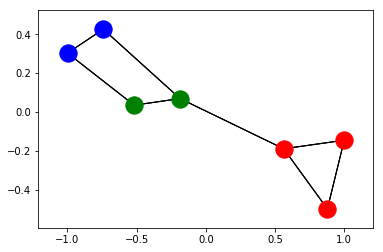

In [266]:
plt.figure()
n=0
for c in set(color.values()):
    node_group=[node for node in color if color[node]==c]
    nx.draw_networkx_nodes(G,pos,nodelist=node_group, node_color=color_list[n])
    n=n+1
    nx.draw_networkx_edges(G,pos)
plt.show()

Recomputing the modularity we have 

In [267]:
print('Q =',Louvain.modularity(Weight,color))

Q = 0.4901960784313726


So that seems to have worked, however, there may still be room for improvement. The next stage of the algorithm looks to see if an improvement can be made by merging any pair of communities. 

## Merging communities
We make a new network with each color as a community 

In [268]:
# start by creating a Weight dictionary where all the pairs have weight 0
new_weight={}

for c_i in set(color.values()):
    for c_j in set(color.values()):
        new_edge=tuple(sorted((c_i,c_j)))
        if new_edge not in new_weight:
            new_weight[new_edge]=0
# for each of the old edges, add its weight to the weight of the appropriate new edge
for edge in Weight:
    # new-edge is the edge between two colors 
    new_edge=tuple(sorted((color[edge[0]],color[edge[1]])))
    # once we know which new edge to add to, we can add it
    new_weight[new_edge]=new_weight[new_edge]+Weight[edge]

print('color:',color)
print('new weight',new_weight)

color: {'a': 'c2', 'b': 'c2', 'c': 'c2', 'd': 'c4', 'e': 'c4', 'f': 'c6', 'g': 'c6'}
new weight {('c2', 'c2'): 5, ('c2', 'c6'): 0, ('c2', 'c4'): 1, ('c6', 'c6'): 5, ('c4', 'c6'): 2, ('c4', 'c4'): 4}


Everything we have done up to here is combined into one function in the Louvain module. The function $\verb|modulize|$ takes the dictionary Weight as input and gives a new graph as output. There next stage of the algorithm simply involves putting the the new network through the $\verb|modulize|$ process repeatedly until no more changes occur.

In [269]:
new_weight,new_color=Louvain.modulize(new_weight)

print('color:',new_color)

color: {'c2': 'c0', 'c4': 'c1', 'c6': 'c2'}


Since the new color dictionary only tells us how the old colors have changed, the color of the nodes is now the color of the color it became during the first iteration. To get a dictionary that maps the actual node to its new color we do

In [270]:
final_color={}
for i in nodes:
    final_color[i]=new_color[color[i]]  
print('Final color',final_color)

Final color {'a': 'c0', 'b': 'c0', 'c': 'c0', 'd': 'c1', 'e': 'c1', 'f': 'c2', 'g': 'c2'}


Lets take a look, 

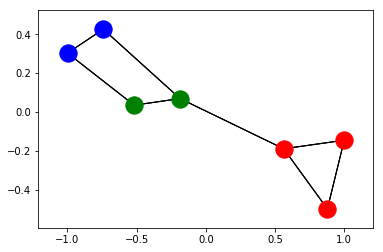

In [271]:
plt.figure()
n=0
for c in set(color.values()):
    node_group=[node for node in color if color[node]==c]
    nx.draw_networkx_nodes(G,pos,nodelist=node_group, node_color=color_list[n])
    n=n+1
    nx.draw_networkx_edges(G,pos)
plt.show()

The only thing that has changed is the names of the colors; that means we have reached a local optimum!

We can automate this process in a 'while' loop that stops when there is no change between two iterations. Note that each time we iterate we need to keep track of the colors of each node. The following code performs this on our original graph (named 'graph') and outputs the final coloring:

In [272]:
end_loop=False
number_of_modules=len(nodes)
final_color={}
for i in nodes:
    final_color[i]=i
#stopping criteria: no change has occured
while end_loop==False:     
    #partition produces 0) the partition 1) a dictionary of similarities between groups partition     
    graph,color=Louvain.modulize(graph)
    for i in nodes:
        final_color[i]=color[final_color[i]]  

    # if number of modules is the same then end the loop
    if number_of_modules==len(set(color.values())):
        end_loop=True
    else:
        number_of_modules=len(set(color.values()))  
print(final_color)

{'a': 'c0', 'b': 'c0', 'c': 'c0', 'd': 'c1', 'e': 'c1', 'f': 'c2', 'g': 'c2'}


## Real networks

First we need to read the files and put them in the desired format

In [273]:
import pandas as pd
# choose a network from shark_0, parakeet_2_2, stumptailed_macaque, Howler_monkeys, Macaques_Massen
network='stumptailed_macaque'
df=pd.read_csv('Data/'+network+'_edgelist.csv')

graph={}
for i,row in df.iterrows():
    graph[(row['ID1'],row['ID2'])]=row['Weight']
    
color=Louvain.get_colors(graph)

Often it is better to have the result in the form of a partition

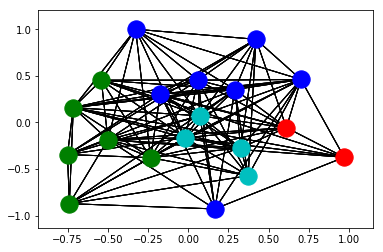

In [274]:
plt.figure()
G=nx.Graph()
for edge in graph:
    G.add_edge(edge[0],edge[1],weight=graph[edge])
pos=nx.spring_layout(G)

n=0
for c in set(color.values()):
    node_group=[node for node in color if color[node]==c]
    nx.draw_networkx_nodes(G,pos,nodelist=node_group, node_color=color_list[n])
    n=n+1
    nx.draw_networkx_edges(G,pos)
plt.show()

In [275]:
Q=Louvain.modularity(graph,color)
print(Q)

0.27721936051
